Loaded 4776770 embeddings with 384 dimensions
Length range: 5000 - 10208085
Loaded k-mer data: (4776770, 2773)
6-mers: 2080 features
5-mers: 512 features
4-mers: 136 features
3-mers: 32 features
2-mers: 10 features
1-mers: 2 features

Number of pairwise distances: 499,500
Distance range: 3.33 - 39.82
Mean: 19.89, Std: 5.27


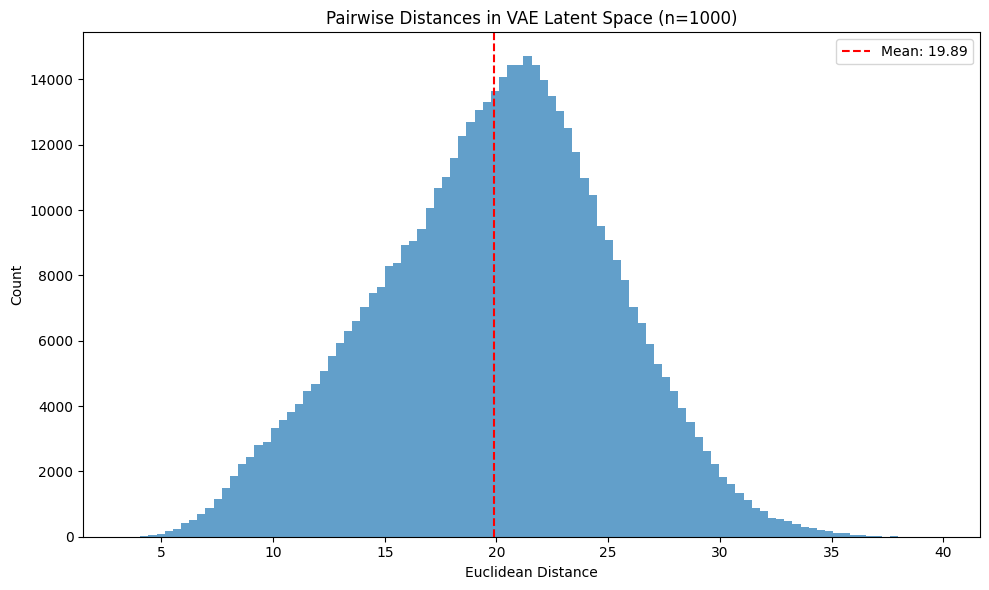

In [1]:
import numpy as np
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

# Load embeddings (col 0 = length, cols 1-384 = embeddings)
data = np.load('Data/all_embeddings.npy')
lengths = data[:, 0]
embeddings = data[:, 1:]
print(f'Loaded {embeddings.shape[0]} embeddings with {embeddings.shape[1]} dimensions')
print(f'Length range: {lengths.min():.0f} - {lengths.max():.0f}')

# Load k-mer frequencies (col 0 = length, cols 1-2772 = k-mers)
kmers = np.load('Data/all_kmers.npy')
print(f'Loaded k-mer data: {kmers.shape}')

# Extract k-mer frequencies by size (new format without 7-mers)
six_mers = kmers[:, 1:2081]        # 2080 features
five_mers = kmers[:, 2081:2593]    # 512 features
four_mers = kmers[:, 2593:2729]    # 136 features
three_mers = kmers[:, 2729:2761]   # 32 features
two_mers = kmers[:, 2761:2771]     # 10 features
one_mers = kmers[:, 2771:2773]     # 2 features

print(f'6-mers: {six_mers.shape[1]} features')
print(f'5-mers: {five_mers.shape[1]} features')
print(f'4-mers: {four_mers.shape[1]} features')
print(f'3-mers: {three_mers.shape[1]} features')
print(f'2-mers: {two_mers.shape[1]} features')
print(f'1-mers: {one_mers.shape[1]} features')

# Randomly sample 1,000 entries
rng = np.random.default_rng(42)
idx = rng.choice(len(embeddings), size = 1000, replace = False)
sample = embeddings[idx]

# Calculate pairwise Euclidean distances
distances = pdist(sample, metric = 'euclidean')
print(f'\nNumber of pairwise distances: {len(distances):,}')
print(f'Distance range: {distances.min():.2f} - {distances.max():.2f}')
print(f'Mean: {distances.mean():.2f}, Std: {distances.std():.2f}')

# Plot histogram
fig, ax = plt.subplots(figsize = (10, 6))
ax.hist(distances, bins = 100, edgecolor = 'none', alpha = 0.7)
ax.axvline(distances.mean(), color = 'red', linestyle = '--', label = f'Mean: {distances.mean():.2f}')
ax.set_xlabel('Euclidean Distance')
ax.set_ylabel('Count')
ax.set_title('Pairwise Distances in VAE Latent Space (n=1000)')
ax.legend()
plt.tight_layout()
plt.show()

Number of pairwise distances: 499,500
Distance range: 0.2281 - 1.3914
Mean: 0.9975, Std: 0.1140


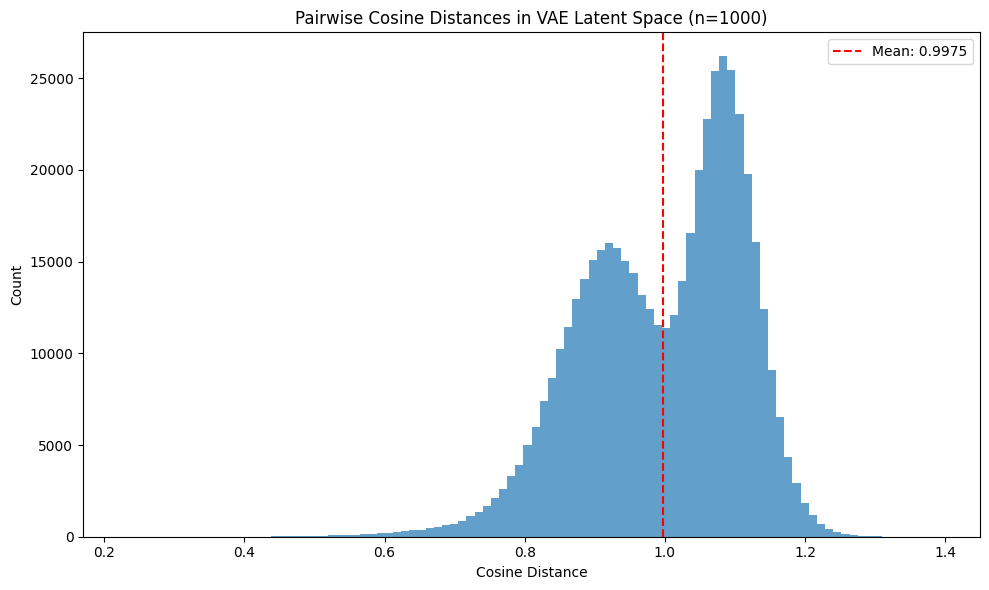

In [2]:
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

# Calculate pairwise cosine distances (using same sample)
cosine_distances = pdist(sample, metric = 'cosine')
print(f'Number of pairwise distances: {len(cosine_distances):,}')
print(f'Distance range: {cosine_distances.min():.4f} - {cosine_distances.max():.4f}')
print(f'Mean: {cosine_distances.mean():.4f}, Std: {cosine_distances.std():.4f}')
# Plot histogram
fig, ax = plt.subplots(figsize = (10, 6))
ax.hist(cosine_distances, bins = 100, edgecolor = 'none', alpha = 0.7)
ax.axvline(cosine_distances.mean(), color = 'red', linestyle = '--', label = f'Mean: {cosine_distances.mean():.4f}')
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Count')
ax.set_title('Pairwise Cosine Distances in VAE Latent Space (n=1000)')
ax.legend()
plt.tight_layout()
plt.show()

Distances from first sequence to 4,776,769 others
Distance range: 0.0000 - 1.6646
Mean: 1.0103, Std: 0.3608


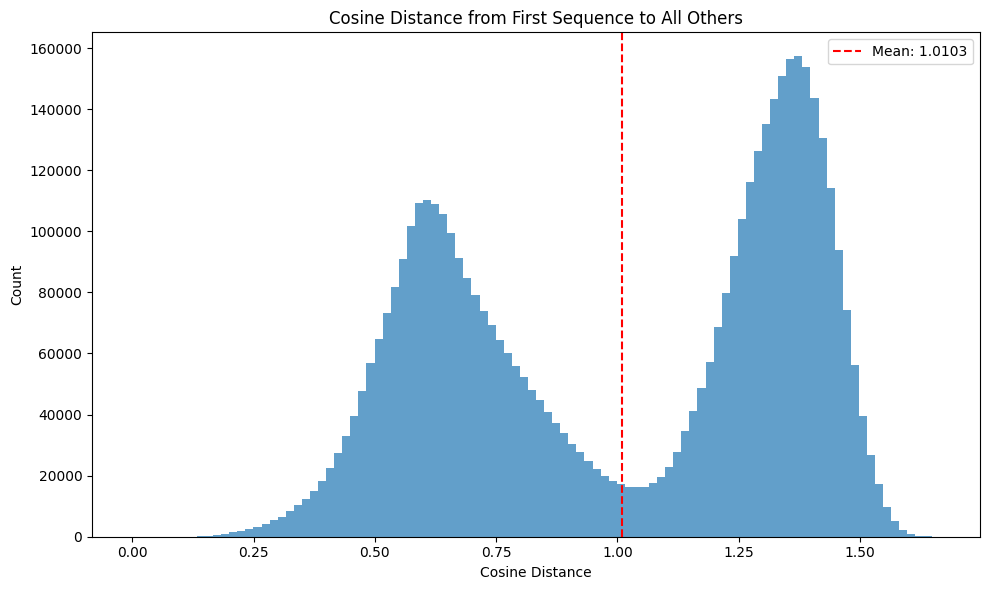

In [5]:
from scipy.spatial.distance import cdist

# Calculate cosine distance from first sequence to all others
first_seq = embeddings[1:2]  # Keep 2D shape
all_others = embeddings[1:]

distances_from_first = cdist(first_seq, all_others, metric = 'cosine').flatten()
print(f'Distances from first sequence to {len(distances_from_first):,} others')
print(f'Distance range: {distances_from_first.min():.4f} - {distances_from_first.max():.4f}')
print(f'Mean: {distances_from_first.mean():.4f}, Std: {distances_from_first.std():.4f}')

# Plot histogram
fig, ax = plt.subplots(figsize = (10, 6))
ax.hist(distances_from_first, bins = 100, edgecolor = 'none', alpha = 0.7)
ax.axvline(distances_from_first.mean(), color = 'red', linestyle = '--', label = f'Mean: {distances_from_first.mean():.4f}')
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Count')
ax.set_title('Cosine Distance from First Sequence to All Others')
ax.legend()
plt.tight_layout()
plt.show()

In [6]:
from scipy.spatial.distance import cdist

first_seq = embeddings[0:1]
distances = cdist(first_seq, embeddings[1:], metric = 'cosine').flatten()
closest_idx = distances.argmin() + 2  # +2 because: +1 for skipping first, +1 for 1-based
print(f'Closest to first: index {closest_idx} (distance: {distances.min():.4f})')

Closest to first: index 105937 (distance: 0.0925)


Loaded k-mer data: (4776770, 2773)
Total 6-mer frequency values: 9,935,681,600
Range: 0.000000 - 0.465941
Mean: 0.000481, Std: 0.000651


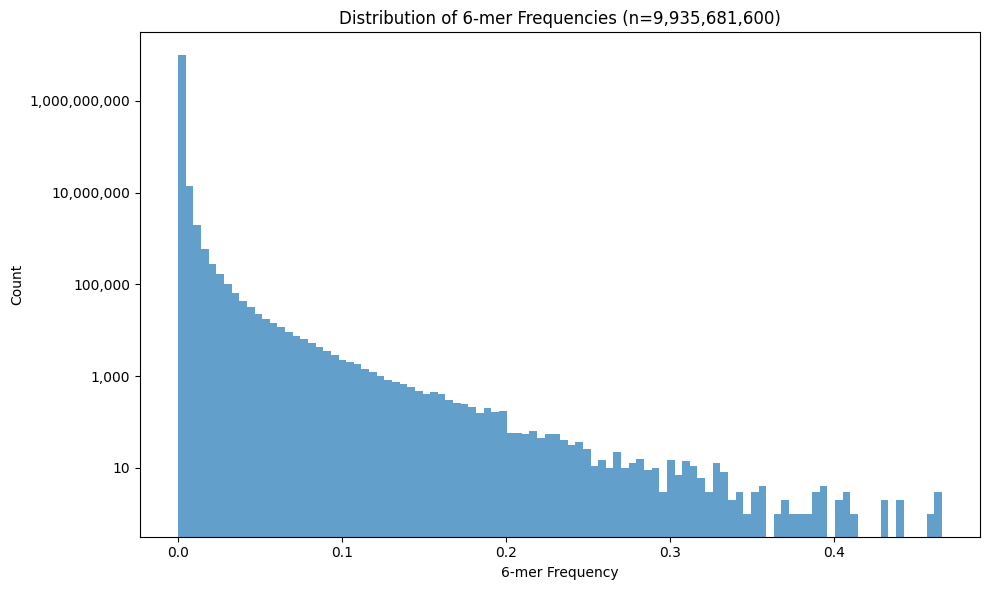

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Load k-mer data
kmers = np.load('Data/all_kmers.npy')
print(f'Loaded k-mer data: {kmers.shape}')

# Extract 6-mer frequencies (columns 1 through 2080, after length column)
six_mer_freqs = kmers[:, 1:2081].flatten()
print(f'Total 6-mer frequency values: {len(six_mer_freqs):,}')
print(f'Range: {six_mer_freqs.min():.6f} - {six_mer_freqs.max():.6f}')
print(f'Mean: {six_mer_freqs.mean():.6f}, Std: {six_mer_freqs.std():.6f}')

# Plot histogram
fig, ax = plt.subplots(figsize = (10, 6))
ax.hist(six_mer_freqs, bins = 100, edgecolor = 'none', alpha = 0.7)
ax.set_xlabel('6-mer Frequency')
ax.set_ylabel('Count')
ax.set_title(f'Distribution of 6-mer Frequencies (n={len(six_mer_freqs):,})')
ax.set_yscale('log')
ax.yaxis.set_major_locator(plt.LogLocator(base = 10, numticks = 10))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}' if x >= 1 else ''))
plt.tight_layout()
plt.show()

6-mer rarity analysis (threshold: 1%)
Total 6-mers per sequence: 2080
Rare 6-mers per sequence (< 1%):
  Mean: 2079.4
  Min: 1991
  Max: 2080
  Median: 2080


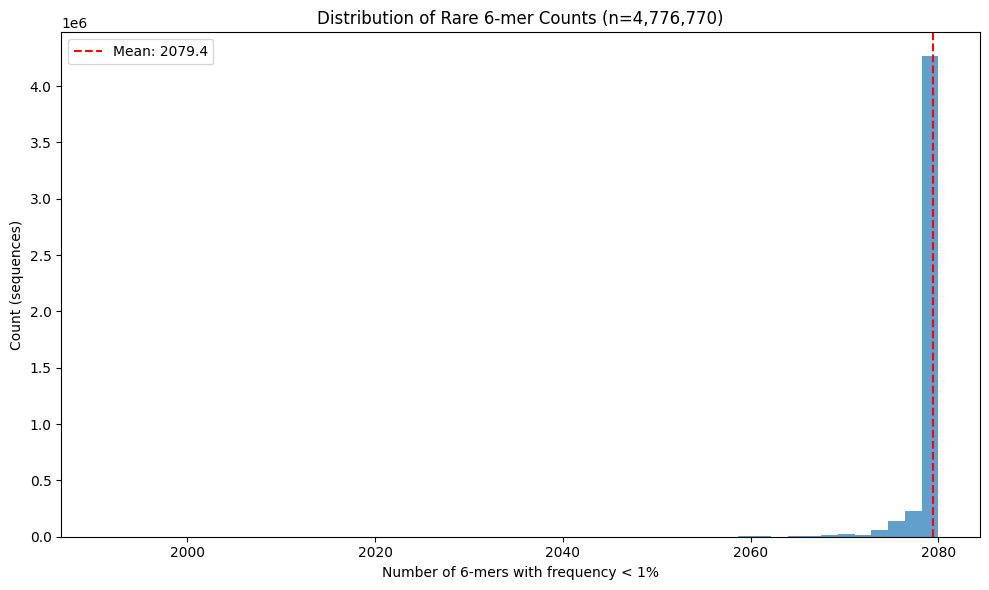

In [5]:
# Analyze 6-mer frequency distribution
# How many 6-mers occur less than 1% of the time
threshold = 0.01
rare_counts = np.sum(six_mers < threshold, axis = 1)

print(f'6-mer rarity analysis (threshold: {threshold * 100:.0f}%)')
print(f'Total 6-mers per sequence: {six_mers.shape[1]}')
print(f'Rare 6-mers per sequence (< {threshold * 100:.0f}%):')
print(f'  Mean: {rare_counts.mean():.1f}')
print(f'  Min: {rare_counts.min()}')
print(f'  Max: {rare_counts.max()}')
print(f'  Median: {np.median(rare_counts):.0f}')

# Plot histogram
fig, ax = plt.subplots(figsize = (10, 6))
ax.hist(rare_counts, bins = 50, edgecolor = 'none', alpha = 0.7)
ax.axvline(rare_counts.mean(), color = 'red', linestyle = '--', label = f'Mean: {rare_counts.mean():.1f}')
ax.set_xlabel(f'Number of 6-mers with frequency < {threshold * 100:.0f}%')
ax.set_ylabel('Count (sequences)')
ax.set_title(f'Distribution of Rare 6-mer Counts (n={len(rare_counts):,})')
ax.legend()
plt.tight_layout()
plt.show()